In [1]:
#using DifferentialEquations



In [1]:
using Plots

In [2]:
### Object declaration
mutable struct Particle
    # Position
    x::Float64
    y::Float64
    # Velocity
    v_x::Float64
    v_y::Float64
    # Other properties: mass, charge
    m::Float64
    q::Float64
    
    # Constructors
    Particle(x, y, v_x, v_y, m, q) = new(x, y, v_x, v_y, m, q)
    Particle(x, y, v_x, v_y) = new(x, y, v_x, v_y, 1, 0)
    
end

function phase_trajectories(p::Particle)
    return (p.x, p.y, p.v_x, p.v_y)
end
#particles = [Particle(i, 2*i, i, i, i, i) for i in 1:3]

phase_trajectories (generic function with 1 method)

In [3]:
K = -10
x = 2.
y = 1.5
#p1 = Particle(0.0, 0.0, 0.0, 1.0)
#p2 = Particle(1, 0.8, 0.5, 0.5)
#particles = [p1, p2]

t_span = (0.0,3.0)
#N_steps = 1000


#function foo(p::Particle)
#    [p.v_x, p.v_y,  K / p.m * (p.x - x) / ((p.x - x)^2 + (p.y - y)^2)^3,K / p.m * (p.y - y) / ((p.x - x)^2 + (p.y - y)^2)^3]
#end
#function foo(u,p,t) 
#    return  [u[3], 
#            u[4],  
#            K * (u[1] - u[5]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[2] - u[6]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            u[7],
#            u[8],
#            K * (u[5] - u[1]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[6] - u[2]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3]
#            
#end

#function RK4(u, f::Function, dt)
#    k1 = f()
#end

function Forces(p::Particle, dt)
    x = 0.0
    y = 0.0
    (a1, a2) =  [p.x-x, p.y-y] * K/(sqrt((p.x-x)^2 + (p.y-y)^2)^3)
    (p.v_x, p.v_y) = [p.v_x, p.v_y] + dt * [a1, a2]
    (p.x, p.y) = [p.x, p.y] + [p.v_x, p.v_y] + dt * [a1, a2]/2) * dt^2
end

function trajectory(p::Particle, t_range::Tuple, N)
    dt = (t_range[2]-t_range[1])/N
    trajectory = zeros(N+1, 4)
    trajectory[1,:] = [p.x, p.y, p.v_x, p.v_y]
    
    for i in 2:(N+1)
        Forces(p, dt)
        trajectory[i,:] = [p.x, p.y, p.v_x, p.v_y]
    end
    
    return trajectory
end

#phase_trajectories(p1)

#u[:,1] = [p.x,p.y,p.v_x,p.v_y]
#u_0 = Float64[i for j in particles for i in phase_trajectories(j)]
#prob = ODEProblem(foo, u_0, t_span)

#sol = solve(prob)
#plot(sol)

#foo([1,2,1,33], 0, 0)

LoadError: syntax: extra token ")" after end of expression

In [107]:
sol = trajectory(Particle(1,1,1,0,1,0), (0,1), 100)

LoadError: UndefVarError: trajectory not defined

In [73]:
### Proportionality constant
κ = 4.
### Particle cross section radius
σ = 0.1
### Restitution coefficient
ρ = 1.
### Number of particles
N = 100
### Box dimensions
dims = (-1.,1.)
### Box effect [left, right, bottom, top], 1 = normal restitution, >1 = acceleration, <1 = decceleration
effect = (1, 1, 1, 1)


function forces(particles, i, dt)
    position = zeros(4)
    p = particles[i]

    position[3:4] .= [p.v_x, p.v_y]
    position[1:2] .= [p.x, p.y]
    for (index, p_other) in enumerate(particles)         
        if(index != i)   
            (a1, a2) = [p.x-p_other.x, p.y-p_other.y] * p.q*p_other.q*κ/p.m /
                       (sqrt((p.x-p_other.x)^2 + (p.y-p_other.y)^2)^3)
            
            position[3:4] .= position[3:4] + dt * [a1, a2]
            position[1:2] .= position[1:2] + [p.v_x, p.v_y]*dt + [a1, a2]/2 * dt^2
            
        end
        
    end
    return position
end

function trajectories(particles, t_range::Tuple, N)
    dt = (t_range[2] - t_range[1])/N
    trajectories = zeros(N + 1, 4 * length(particles))
    for (index, p) in enumerate(particles)
        trajectories[1, (4*index-3):(4*index)] .= [p.x, p.y, p.v_x, p.v_y]
    end

    for i in 2:(N + 1)
        #for (index, p) in enumerate(particles)
        #    Collisions(particles, index, dt)
        #end
        
        for (index, p) in enumerate(particles)   
            collisions(particles, index, dt)
            box(p, dt, effect)
            trajectories[i,(4*index-3):(4*index)] .= forces(particles, index, dt)             
        end
        
        # Save positions
        for (index, p) in enumerate(particles)   
            (p.x, p.y, p.v_x, p.v_y) = trajectories[i, (4*index-3):(4*index)]            
        end

    end
    
    return trajectories
end

# Obsolete
function collisions(particles, i)
    p = particles[i]
    for (index, p_other) in enumerate(particles)
        if (index != i)
            if(isCollision(p, p_other))
                println("true")
                direction!(p, p_other)
            end
        end
    end
end

function collisions(particles, i, dt)
    p = particles[i]
    for (index, p_other) in enumerate(particles)
        if (index != i)
            if(is_collision(p, p_other, dt))
                #println("true")
                direction!(p, p_other)
            end
        end
    end
end


# Obsolete
function is_collision(p1, p2)
    (p1.x-p2.x)^2 + (p1.y-p2.y)^2 < σ^2 ? true : false
end

function is_collision(p1, p2, dt)
    (p1.x+p1.v_x*dt-p2.x-p2.v_x*dt)^2 + (p1.y+p1.v_y*dt-p2.y-p2.v_y*dt)^2 < σ^2 ? true : false
end

### Change of particle momentum
function direction!(p1, p2)
    μ = p1.m + p2.m
    v_x = (p1.m * p1.v_x + p2.m * p2.v_x) / μ
    v_y = (p1.m * p1.v_y + p2.m * p2.v_y) / μ
    p12v = [
        v_x - p2.m * ρ * (p1.v_x - p2.v_x) / μ,
        v_y - p2.m * ρ * (p1.v_y - p2.v_y) / μ]#,
        #v_x + p1.m * ρ * (p1.v_x - p2.v_x) / μ,
        #v_y + p1.m * ρ * (p1.v_y - p2.v_y) / μ
    #]
    #(p1.v_x, p1.v_y, p2.v_x, p2.v_y) = p12v
    (p1.v_x, p1.v_y) = p12v
    
end

### Borders
function box(p, dt, effect)
    px, py, pvx, pvy = p.x, p.y, p.v_x, p.v_y # + 4*p.v_x*dt, p.y + 4*p.v_y*dt
    if (px + pvx*dt <= dims[1]) 
        p.v_x = -p.v_x*effect[1]
        #p.x = dims[1]
    end
    if (px + pvx*dt >= dims[2])
        p.v_x = -p.v_x*effect[2]
        #p.x = dims[2]
    end
    if (py + pvy*dt <= dims[1])
        p.v_y = -p.v_y*effect[3]
        #p.y = dims[1]
    end
    if (py + pvy*dt >= dims[2])
        p.v_y = -p.v_y*effect[4]
        #p.y = dims[2]
    end
end

### Randomly generate particles by criteria
function create_particles(N, μ, charges)
    particles = []
    for i in 1:N
        distr = random_distribution()
        x, y, vx, vy = distr[1][1], distr[1][2], distr[2][1], distr[2][2]
        p = Particle(x, y, vx, vy)
        push!(particles, p)
    end
    return particles
end

function maxwell_distribution(N, μ)
    f(v) = sqrt(1/π)*exp(-(v - μ)^2)

    velocities = []
    
    for i in 1:N
        
    end
end

function random_distribution()
    #position = 2*((dims[2]-σ)*rand(Float64, (2,1))) - ((dims[2]-σ)*[1,1])
    #velocity = 2*dims[2]*rand(Float64, (2,1)) - dims[2]*[1,1]
    position = (dims[2]-dims[1]-4*σ)*rand(Float64, (2,1)) + (dims[1]+2*σ)*[1,1]
    velocity = (dims[2]-dims[1]-4*σ)*rand(Float64, (2,1)) + (dims[1]+2*σ)*[1,1]
    return [position, velocity]
end

random_distribution (generic function with 1 method)

In [641]:
p1 = Particle(1.5,0,2,0, 1, 0)
p2 = Particle(1,1,-0.5,-1, 1, -1)
#p3 = Particle(0,0.09,-1,0)
#p4 = Particle(-1,0,1,0)
#p5 = Particle(-0.5,0.5,0,-1)
particles = [p1, p2] #, p3, p4,p5]
#particles = [p3, p4, p5]

2-element Array{Particle,1}:
 Particle(1.5, 0.0, 2.0, 0.0, 1.0, 0.0)
 Particle(1.0, 1.0, -0.5, -1.0, 1.0, -1.0)

In [74]:
particles = create_particles(10, 0, 0)

10-element Array{Any,1}:
 Particle(-0.13638576384092538, 0.7209769240824329, -0.5512417387073523, -0.6134151545819851, 1.0, 0.0)
 Particle(0.6009847657561374, 0.2651074730898977, -0.6122427136741373, 0.4646421219754735, 1.0, 0.0)
 Particle(-0.40148672388484635, 0.18913524444104224, 0.5607771516169471, 0.06892340850471435, 1.0, 0.0)
 Particle(0.22344674438086853, -0.6859234398940406, 0.2807628182006634, 0.40140403707792927, 1.0, 0.0)
 Particle(0.03528527638597223, 0.7933736385143018, 0.39741808379054566, 0.008792638900409266, 1.0, 0.0)
 Particle(0.321699960455603, -0.6056069728219878, -0.30995705028390824, -0.24052028983251394, 1.0, 0.0)
 Particle(-0.33693515431195886, -0.6605421514203726, 0.40490737431475665, -0.5434528112919754, 1.0, 0.0)
 Particle(-0.6678656583436485, -0.6530108338551902, 0.30574697193119005, -0.6831345861741263, 1.0, 0.0)
 Particle(0.49318645109435555, -0.5141134053497118, -0.7000493217975567, -0.18114612125559904, 1.0, 0.0)
 Particle(0.41654044403756707, 0.30596145

In [75]:
sol = trajectories(particles, (0,4), 1000)

1001×40 Array{Float64,2}:
 -0.136386  0.720977  -0.551242  -0.613415  …  0.305961  -0.243267   0.700514
 -0.15623   0.698894  -0.551242  -0.613415     0.33118   -0.243267   0.700514
 -0.176075  0.676811  -0.551242  -0.613415     0.356398  -0.243267   0.700514
 -0.19592   0.654728  -0.551242  -0.613415     0.381617  -0.243267   0.700514
 -0.215765  0.632645  -0.551242  -0.613415     0.406836  -0.243267   0.700514
 -0.235609  0.610562  -0.551242  -0.613415  …  0.432054  -0.243267   0.700514
 -0.255454  0.588479  -0.551242  -0.613415     0.457273  -0.243267   0.700514
 -0.275299  0.566396  -0.551242  -0.613415     0.482491  -0.243267   0.700514
 -0.295143  0.544313  -0.551242  -0.613415     0.50771   -0.243267   0.700514
 -0.314988  0.52223   -0.551242  -0.613415     0.532928  -0.243267   0.700514
 -0.334833  0.500147  -0.551242  -0.613415  …  0.558147  -0.243267   0.700514
 -0.354677  0.478065  -0.551242  -0.613415     0.583365  -0.243267   0.700514
 -0.374522  0.455982  -0.551242  -0.61

In [6]:
p1
#p2

LoadError: UndefVarError: p1 not defined

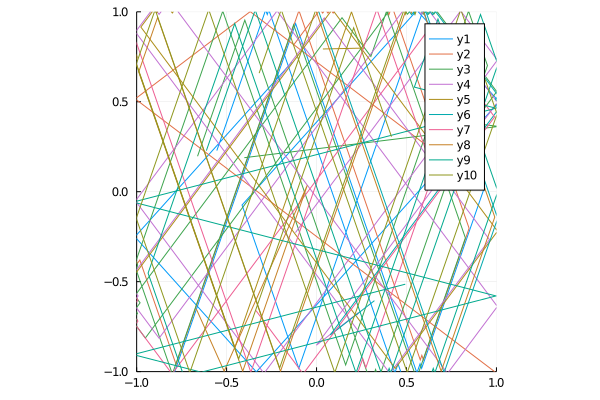

In [76]:

plot(sol[:,1], sol[:,2], lims=dims, aspect_ratio=:equal)
for (index, p) in enumerate(particles)
    if index == 1
        continue
    end
    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
end
current()


In [16]:
#@userplot CirclePlot
#@recipe function f(cp::CirclePlot)
#    x, y, i = cp.args
#    n = length(x)
#    inds = circshift(1:n, 1 - i)
#    linewidth --> range(0, 10, length = n)
#    seriesalpha --> range(0, 1, length = n)
#    aspect_ratio --> 1
#    label --> false
#    x[inds], y[inds]
#end

#@userplot plot_particles
#@recipe function p(cp::plot_particles)
function plot_particles(sol)
    N = length(sol[:,1])
    plot(sol[i,1], sol[i,2], lims=dims, aspect_ratio=:equal)
    #for (index, p) in enumerate(particles)
    #    if index == 1
    #        continue
    #    end
    #    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
    #end
    #current()
end
#current()
plt = plot(
    legend = false,
    xlims = dims,
    ylims = dims
    #linewidth = range(1, 20; length = n),
    #color = palette(:viridis, n),
    #axis = nothing,
    #border = :none
)

anim = Animation()

for i in 1:length(sol[:,1])
    push!(plt, i, [sol[i,1], sol[i,2]])
    frame(anim)
end

#gif(anim, "animsincos.gif", fps = 15)

#anim = @animate for i ∈ 1:length(sol[:,1])
#    plot_particles(sol, i)
#end

In [55]:

@userplot pl_particles
@recipe function f(cp::pl_particles, add_marker = true)
#    x, y, i = cp.args
    x, y= cp.args
    #n = length(x)
    #inds = circshift(1:n, 1 - i)
    #linewidth --> range(0, 10, length = n)
    #seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    lims --> dims
    markershape --> :circle
    x, y
   # scatter(x, y)
end


#@userplot plot_particles
#@recipe function p(cp::plot_particles)

┌ Info: Saved animation to 
│   fn = /Users/tadeasnemec/Programming/Git/Particles_In_Box/anim_fps15.gif
└ @ Plots /Users/tadeasnemec/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/tadeasnemec/Programming/Git/Particles_In_Box/anim_fps15.gif")
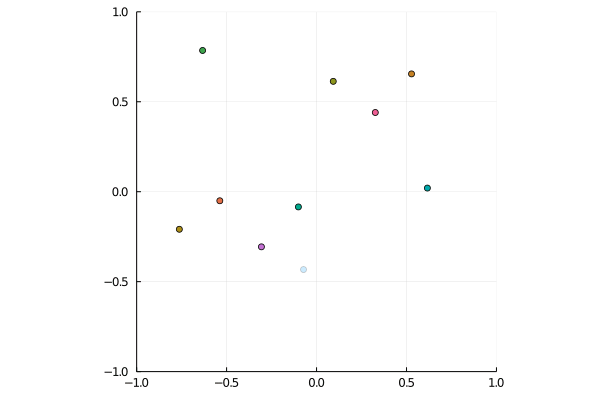

In [68]:
anim = @animate for i ∈ 1:length(sol[:,1])
    pl_particles(sol[i:i,1], sol[i:i,2], marker = (2*σ))
    for (index, p) in enumerate(particles)
        if index == 1
            continue
        end
        pl_particles!(sol[i:i,(4*index-3)], sol[i:i,(4*index-2)])
    end
end
gif(anim, "anim_fps15.gif", fps = 100)

